In [1]:
!jupyter kernelspec list

Available kernels:
  ap2               /p/home/jusers/haque1/juwels/.local/share/jupyter/kernels/ap2
  ap2_hf-llm-bnb    /p/home/jusers/haque1/juwels/.local/share/jupyter/kernels/ap2_HF-LLM-BnB
  bootcamp2022      /p/home/jusers/haque1/juwels/.local/share/jupyter/kernels/bootcamp2022
  python3           /usr/local/share/jupyter/kernels/python3


In [1]:
# Import necessary libraries
import sys
import pathlib
import string
import re
import os
import logging
import functools

# Add the scripts folder to the system path
sys.path.append("../scripts")
import normalize_text_bootcamp
import utils_bootcamp
import plotting

logging.basicConfig(level=logging.INFO)

# Import data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray

# PyTorch for deep learning
import torch
import torch.nn.functional

# Scikit-learn for data processing and metrics
import sklearn.metrics
import sklearn.model_selection

# Hugging Face for DeBERTa model
import datasets
import transformers


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Load the dataset
file_path = '/p/project/deepacf/maelstrom/haque1/dataset/tweets_2017_01_era5_normed_filtered.nc'
ds_tweets = xarray.load_dataset(file_path)

In [3]:
ds_tweets

<xarray.Dataset>
Dimensions:                       (index: 24491)
Coordinates:
  * index                         (index) int64 0 1 2 3 ... 24488 24489 24490
Data variables: (12/41)
    text                          (index) object 'A Chinese proverb relevant ...
    conversation_id               (index) object '819543073092931584' ... '81...
    lang                          (index) object 'en' 'en' 'en' ... 'en' 'en'
    source                        (index) object 'Twitter for Android' ... 'T...
    author_id                     (index) object '761805493' ... '402768458'
    created_at                    (index) datetime64[ns] 2017-01-12T13:54:29 ...
    ...                            ...
    station_distance_km           (index) float64 4.766 6.961 ... 6.961 7.548
    tp_h_mm                       (index) float64 0.8418 0.0 ... 0.005879
    raining_station               (index) float64 1.0 0.0 0.0 ... 1.0 0.0 0.0
    tp_mm_radar                   (index) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tp_mm_station                 (index) float64 1.2e+03 0.0 0.0 ... 0.0 0.0
    raining_radar                 (index) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  added locationsadded locationsadded locationsadded location...

In [4]:
key_tp = "tp_h"
ds_tweets["raining"] = (["index"], ds_tweets[key_tp].values > 1e-8)

indices_train, indices_test = sklearn.model_selection.train_test_split(
    np.arange(ds_tweets["index"].shape[0]),
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=ds_tweets["raining"].values
)

In [5]:
ds_tweets

<xarray.Dataset>
Dimensions:                       (index: 24491)
Coordinates:
  * index                         (index) int64 0 1 2 3 ... 24488 24489 24490
Data variables: (12/41)
    text                          (index) object 'A Chinese proverb relevant ...
    conversation_id               (index) object '819543073092931584' ... '81...
    lang                          (index) object 'en' 'en' 'en' ... 'en' 'en'
    source                        (index) object 'Twitter for Android' ... 'T...
    author_id                     (index) object '761805493' ... '402768458'
    created_at                    (index) datetime64[ns] 2017-01-12T13:54:29 ...
    ...                            ...
    station_distance_km           (index) float64 4.766 6.961 ... 6.961 7.548
    tp_h_mm                       (index) float64 0.8418 0.0 ... 0.005879
    raining_station               (index) float64 1.0 0.0 0.0 ... 1.0 0.0 0.0
    tp_mm_radar                   (index) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tp_mm_station                 (index) float64 1.2e+03 0.0 0.0 ... 0.0 0.0
    raining_radar                 (index) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  added locationsadded locationsadded locationsadded location...

In [6]:
# plt.hist(indices_train, bins=np.unique(indices_train), alpha=0.5, label='Training Set')
# plt.hist(indices_test, bins=np.unique(indices_test), alpha=0.5, label='Test Set')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.title('Label Distribution in Training and Test Set')
# plt.legend()
# plt.show()

In [7]:
# Load the pretrained tokenizer
model_nm = "/p/project/deepacf/maelstrom/haque1/deberta-v3-small"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_nm)
db_config_base = transformers.AutoConfig.from_pretrained(model_nm, num_labels=2)
# Function to tokenize text
def tokenize_function(examples):
    return tokenizer(examples["inputs"], padding=True, truncation=True)

# Prepare the dataset for the Hugging Face model
def get_dataset(ds, tokenizer, indices_train, indices_test):
    df = ds[["text_normalized", "raining"]].to_dataframe()
    df = df.rename(columns={"text_normalized": "inputs", "raining": "label"})
    datasets_ds = datasets.Dataset.from_pandas(df)
    tok_ds = datasets_ds.map(tokenize_function, batched=True)
    train_dataset = tok_ds.select(indices_train)
    test_dataset = tok_ds.select(indices_test)
    return datasets.DatasetDict({"train": train_dataset, "test": test_dataset})

# Create the dataset
dataset = get_dataset(ds_tweets, tokenizer, indices_train, indices_test)


/transformers/src/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 24491/24491 [00:00<00:00, 25134.96 examples/s]


In [8]:
# Define hyperparameters
parameters = {
    "learning_rate": 8e-5,
    "batch_size": 16,
    "weight_decay": 0.01,
    "epochs": 1,
    "warmup_ratio": 0.1,
    "cls_dropout": 0.3,
    "lr_scheduler_type": "cosine"
}

# Specify your personal folder for model outputs
FOLDER_TO_OUTPUT = "/p/project/deepacf/maelstrom/your_user/model/"

# Function to get the model
def get_model(params, db_config_base, model_nm):
    db_config = db_config_base
    if params is not None:
        db_config.update({"cls_dropout": params["cls_dropout"]})
    db_config.update({"num_labels": 2})
    model = transformers.AutoModelForSequenceClassification.from_pretrained(model_nm, config=db_config)
    return model

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"f1": sklearn.metrics.f1_score(labels, predictions)}

# Function to get the trainer
def get_trainer(dataset, parameters):
    training_args = transformers.TrainingArguments(
        output_dir=FOLDER_TO_OUTPUT,
        learning_rate=parameters["learning_rate"],
        per_device_train_batch_size=parameters["batch_size"],
        per_device_eval_batch_size=parameters["batch_size"],
        num_train_epochs=parameters["epochs"],
        weight_decay=parameters["weight_decay"],
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        save_strategy="epoch",
        warmup_ratio=parameters["warmup_ratio"]
    )

    return transformers.Trainer(
        model_init=lambda: get_model(parameters, db_config_base, model_nm),
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        compute_metrics=compute_metrics
    )


In [9]:
# Initialize the trainer
trainer = get_trainer(dataset, parameters)




2023-12-11 12:01:11.262991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 12:01:12.590274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /p/project/deepacf/maelstrom/haque1/deberta-v3-small and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can 

In [10]:
# Start training
trainer.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /p/project/deepacf/maelstrom/haque1/deberta-v3-small and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:apscheduler.scheduler:Added job "EmissionsTracker._measure_power" to job store "default"
INFO:apscheduler.scheduler:Scheduler started


ValueError: expected sequence of length 36 at dim 1 (got 35)

In [ ]:
# Evaluate the model on the test set
results = trainer.evaluate()

# Load the test dataset
test_dataset = prepare_dataset(ds_tweets, tokenizer, indices_train, indices_test, train=False)

# Make predictions
predictions = trainer.predict(test_dataset["test"]).predictions
predictions = np.argmax(predictions, axis=1)

# True labels
true_labels = test_dataset["test"]["label"]

# Confusion Matrix
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, predictions)
print(conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_labels, predictions)
auc = sklearn.metrics.auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Prepare the full dataset
full_dataset = prepare_dataset(ds_tweets, tokenizer, indices_train, indices_test)

# Initialize the trainer with the full dataset
full_trainer = get_trainer(full_dataset, parameters)

# Train on the full dataset
full_trainer.train()

# Evaluate and analyze the results as done in Exercise 7


## 2

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DebertaTokenizer, DebertaForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
import torch

# Load your dataset (replace this with your actual loading code)
# For example, if your xarray dataset is named 'dataset':
# df = dataset.to_dataframe()
# Assuming a simple DataFrame with columns 'tweet' and 'label'
df = pd.DataFrame({
    'tweet': ['It is raining today', 'What a sunny day', 'Raining again!', 'No rain today'],
    'label': [1, 0, 1, 0]  # 1 for 'Raining', 0 for 'Not Raining'
})

# Text Preprocessing
# Add any specific text preprocessing here if needed

# Splitting the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet'], df['label'], test_size=0.2)

# Load DeBERTa tokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Create a Dataset object
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
val_dataset = TweetDataset(val_encodings, val_labels.tolist())

# Load DeBERTa model for sequence classification
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset             
)

# Train the model
trainer.train()

# Evaluate the model
evaluation_result = trainer.evaluate()

# Print evaluation results
print("Evaluation results:", evaluation_result)

# Save the model
model.save_pretrained("./deberta_tweet_classifier")


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:apscheduler.scheduler:Adding job tentatively -- it will be properly scheduled when the scheduler starts
INFO:apscheduler.scheduler:Added job "EmissionsTracker._measure_power" to job store "default"
INFO:apscheduler.scheduler:Scheduler started
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


INFO:apscheduler.scheduler:Scheduler has been shut down
INFO:apscheduler.executors.default:Running job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2023-12-11 12:06:00 CET)" (scheduled at 2023-12-11 12:05:45.683187+01:00)
INFO:apscheduler.executors.default:Job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2023-12-11 12:06:00 CET)" executed successfully


Evaluation results: {'eval_loss': 0.7613661289215088, 'eval_runtime': 0.0731, 'eval_samples_per_second': 13.675, 'eval_steps_per_second': 13.675, 'epoch': 3.0}


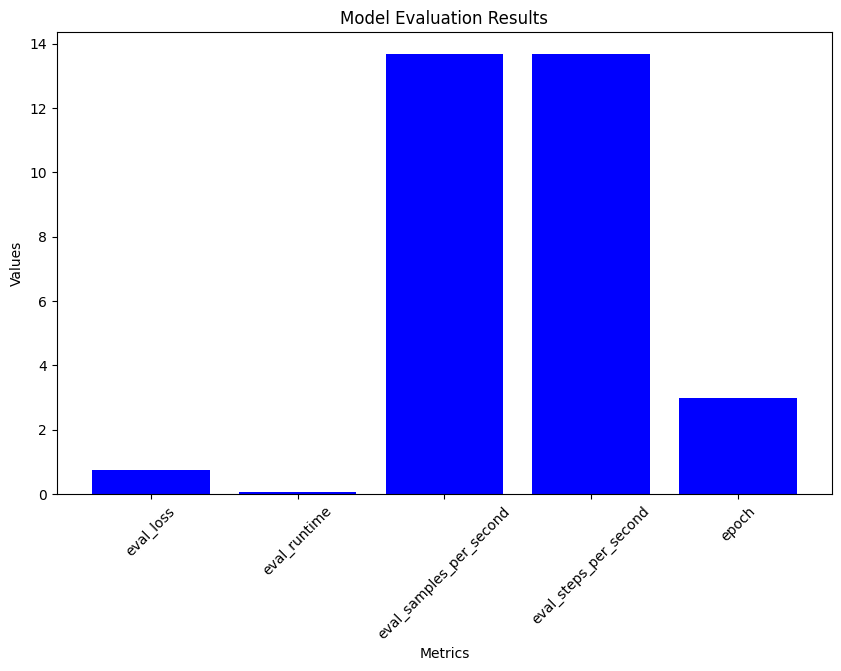

In [12]:
import matplotlib.pyplot as plt

# Assuming 'evaluation_result' contains the results from the trainer.evaluate()
# Example: evaluation_result = {'eval_loss': 0.123, 'eval_accuracy': 0.95, ...}

# Extract metrics
metrics = evaluation_result.keys()
values = [evaluation_result[metric] for metric in metrics]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='blue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Results')
plt.xticks(rotation=45)
plt.show()


# 3

In [1]:
import pandas as pd
import numpy as np
import xarray
import torch
from torch.utils.data import Dataset
from transformers import DebertaTokenizer, DebertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split


2023-12-14 13:14:32.010992: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 13:14:32.011046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 13:14:32.015105: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 13:14:32.425424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
FOLDER_DATA = "/p/project/deepacf/maelstrom/haque1/dataset/"
FOLDER_TWEET = FOLDER_DATA + "tweets_2017_01_era5_normed_filtered.nc"
ds_tweets = xarray.load_dataset(FOLDER_TWEET)

# Define labels based on a condition (e.g., a certain threshold)
key_tp = "tp_h"  # Replace with your key
ds_tweets["raining"] = (["index"], ds_tweets[key_tp].values > 1e-8)

# Split the dataset
indices_train, indices_test = train_test_split(
    np.arange(ds_tweets["index"].shape[0]),
    test_size=0.2,
    random_state=42
)

# Convert the dataset to pandas DataFrame
df = ds_tweets.to_dataframe().reset_index()
df_train = df.loc[df['index'].isin(indices_train)]
df_test = df.loc[df['index'].isin(indices_test)]

train_texts = df_train['text_normalized'].tolist()
train_labels = df_train['raining'].astype(int).tolist()
val_texts = df_test['text_normalized'].tolist()
val_labels = df_test['raining'].astype(int).tolist()


In [3]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


In [4]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)


In [5]:

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)


In [6]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [8]:
trainer.train()


2023/12/14 13:14:43 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vec

Step,Training Loss
10,0.683900
20,0.684300
30,0.682700
40,0.673400
50,0.659100
60,0.668400
70,0.654500
80,0.644700
90,0.645100
100,0.625700


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=921, training_loss=0.5633511997589459, metrics={'train_runtime': 170.7605, 'train_samples_per_second': 344.201, 'train_steps_per_second': 5.394, 'total_flos': 1830215206265472.0, 'train_loss': 0.5633511997589459, 'epoch': 3.0})

In [17]:
evaluation_result = trainer.evaluate()
print("Evaluation results:", evaluation_result)


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Evaluation results: {'eval_loss': 0.6239273548126221, 'eval_runtime': 1.958, 'eval_samples_per_second': 2502.009, 'eval_steps_per_second': 10.214, 'epoch': 3.0}


In [18]:
model.save_pretrained("./deberta_tweet_classifier")


In [19]:
import sys
sys.path.append("../helpers/plotting")
import test_training_distribution
import dataset_length_distribution

In [20]:
test_training_distribution.plot_label_distribution(df, 'raining', title='Distribution of Tweets (Raining vs Not Raining)', x_label='Raining', y_label='Number of Tweets')

AttributeError: module 'test_training_distribution' has no attribute 'plot_label_distribution'

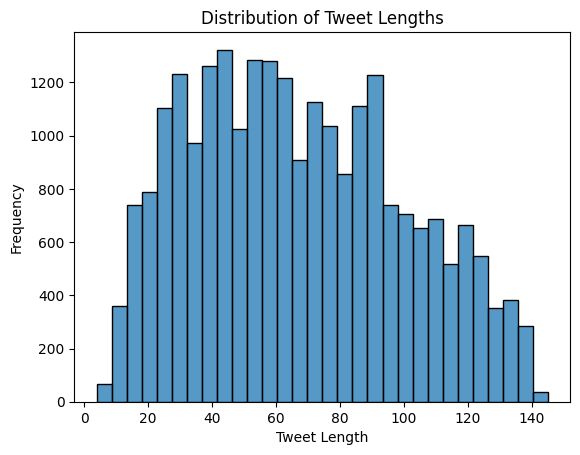

In [21]:
dataset_length_distribution.plot_numeric_distribution(df, 'text_normalized', bins=30, title='Distribution of Tweet Lengths', x_label='Tweet Length', y_label='Frequency')

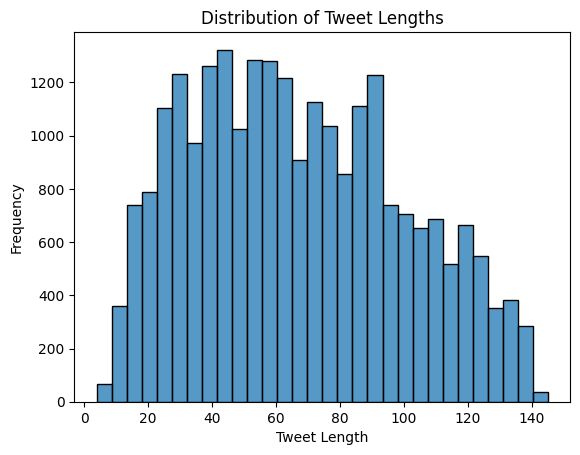

In [78]:
df['tweet_length'] = df['text_normalized'].apply(len)
sns.histplot(df['tweet_length'], bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


In [50]:
# Assuming 'test_ds' is your test dataset in the format expected by Hugging Face
# test_ds = get_dataset(
#     ds_tweets.sel(index=indices_test),
#     tok_func,
#     tokenizer,
#     indices_train,
#     indices_test,
#     train=False
# )
test_ds = val_dataset
# Make predictions
preds_output = trainer.predict(test_ds)


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [51]:
preds = torch.nn.functional.softmax(torch.Tensor(preds_output.predictions), dim=1).numpy()
prediction_probability = preds[:, 1]  # Probability of 'Raining'
predictions = preds.argmax(axis=-1)  # Predicted class (0 or 1)


In [52]:
# This is a selection of your xarray dataset corresponding to the test set
ds_test = ds_tweets.sel(index=indices_test)
truth = ds_test.raining.values  # Actual labels


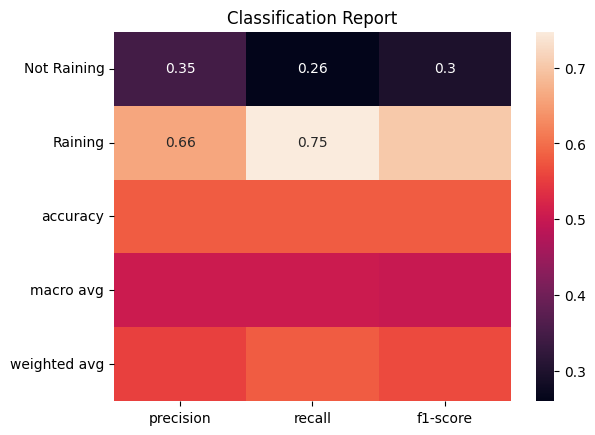

In [53]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'truth' are your model's predictions and the true labels
report = classification_report(truth, predictions, target_names=['Not Raining', 'Raining'], output_dict=True)

# Plotting the classification report
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report')
plt.show()


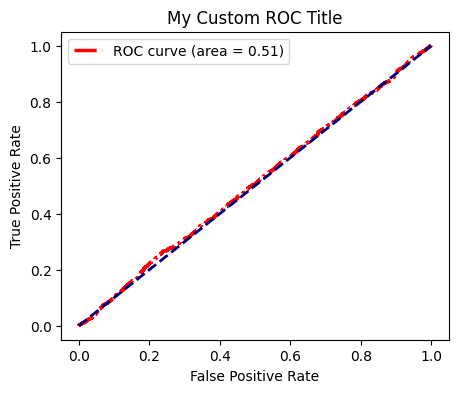

In [55]:
import roc
roc.plot_roc_curve(truth, prediction_probability, title='My Custom ROC Title', color='red', linestyle='-.', linewidth=2.5, legend_loc='upper left', figsize=(5, 4))

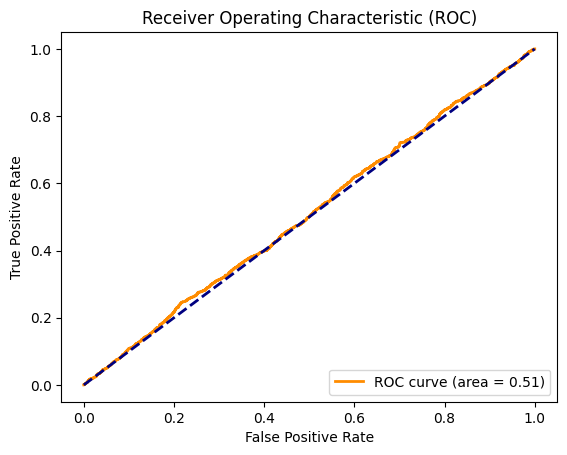

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(truth, prediction_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


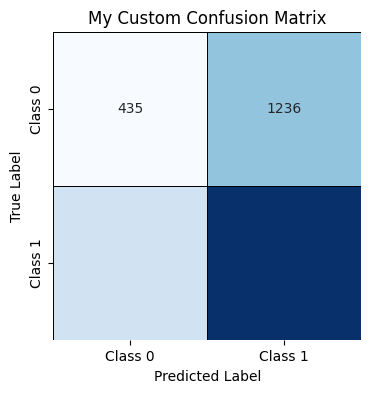

In [63]:
import confusion_matrix
confusion_matrix.plot_confusion_matrix(truth, predictions, labels=['Class 0', 'Class 1'], title='My Custom Confusion Matrix', cmap='Blues', figsize=(5, 4))

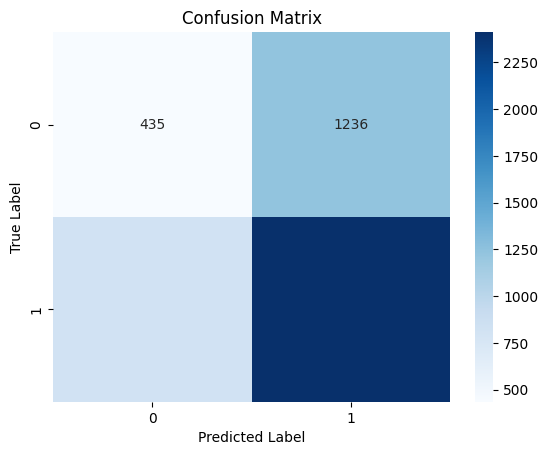

In [59]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(truth, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# 4

In [2]:
import xarray as xr
import sys
import transformers
import datasets
import functools
import xarray as xr
import os
from sklearn.model_selection import train_test_split
sys.path.append("../helpers/plotting")
import test_training_distribution
sys.path.append("../helpers")
from transformer_trainer import get_trainer

ds_raw = xr.open_dataset('/p/project/deepacf/maelstrom/haque1/dataset/tweets_2017_01_era5_normed_filtered.nc')


In [3]:
# again define labels
key_tp = "tp_h"
ds_raw["raining"] = (["index"], ds_raw[key_tp].values > 1e-8)

In [4]:
from sklearn.model_selection import train_test_split

labels = ds_raw['raining']

indices_train, indices_test = train_test_split(ds_raw.index, test_size=0.20, stratify=labels)


In [ ]:
# ds_raw

In [5]:
# test_training_distribution.plot_label_distribution_split(
#     ds_raw.index, [indices_train, indices_test],
#     column='raining',
#     titles=['Training Set Label Distribution', 
#             'Test Set Label Distribution'], 
#     x_label='Label', 
#     y_label='Frequency', 
#     figsize=(12, 6)
# )

In [6]:
# Load the pretrained tokenizer and model configuration
model_nm = "/p/project/deepacf/maelstrom/haque1/deberta-v3-small"  # Path to model
tokenizer = transformers.AutoTokenizer.from_pretrained(model_nm)
db_config_base = transformers.AutoConfig.from_pretrained(model_nm, num_labels=2)

# Define function to tokenize the field 'inputs' stored in x
def tok_func(x, tokenizer):
    return tokenizer(x["inputs"], padding=True, truncation=True, max_length=512)

# Function to convert the dataset to a format used by Hugging Face
def get_dataset(ds, tok_func, tokenizer, indices_train, indices_test, train=True):
    df = ds[["text_normalized", "raining"]].to_pandas()
    df = df.rename(columns={"text_normalized": "inputs", "raining": "labels"})
    datasets_ds = datasets.Dataset.from_pandas(df)
    tok_function_partial = functools.partial(tok_func, tokenizer=tokenizer)
    tok_ds = datasets_ds.map(tok_function_partial, batched=True)
    if train:
        return datasets.DatasetDict({
            "train": tok_ds.select(indices_train), 
            "test": tok_ds.select(indices_test)
        })
    else:
        return tok_ds



/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
dataset = get_dataset(ds_raw, tok_func, tokenizer, indices_train, indices_test)

Map:   0%|          | 0/24491 [00:00<?, ? examples/s]

In [8]:
# dataset

In [9]:
FOLDER_TO_OUTPUT = './outputs' 

In [10]:
parameters = {
    "learning_rate": 8e-5,
    "batch_size": 16,
    "weight_decay": 0.01,
    "epochs": 1,
    "warmup_ratio": 0.1,
    "cls_dropout": 0.3,
    "lr_scheduler_type": "cosine"
}

os.makedirs(FOLDER_TO_OUTPUT, exist_ok=True)




In [13]:
trainer = get_trainer(dataset, db_config_base, model_nm, FOLDER_TO_OUTPUT, parameters)

# Start training
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /p/project/deepacf/maelstrom/haque1/deberta-v3-small and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /p/project/deepacf/maelstrom/haque1/deberta-v3-small and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Not Raining,F1 Raining
1,No log,0.588515,0.449254,0.792638


TrainOutput(global_step=307, training_loss=0.6022606765796773, metrics={'train_runtime': 37.6928, 'train_samples_per_second': 519.781, 'train_steps_per_second': 8.145, 'total_flos': 260117281723776.0, 'train_loss': 0.6022606765796773, 'epoch': 1.0})

In [12]:
import transformers
import datasets
import sklearn.metrics
import functools
import numpy as np
import os


def get_model(params, db_config_base, model_nm):
    db_config = db_config_base
    if params is not None:
        db_config.update({"cls_dropout": params["cls_dropout"]})
    db_config.update({"num_labels": 2})
    model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_nm, config=db_config
    )
    return model

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    classification_report = sklearn.metrics.classification_report(
        labels, predictions, target_names=["not raining", "raining"], output_dict=True
    )
    f1_not_raining = classification_report["not raining"]["f1-score"]
    f1_raining = classification_report["raining"]["f1-score"]
    return {"f1_not_raining": f1_not_raining, "f1_raining": f1_raining}

def get_trainer(dataset, db_config_base, model_nm, FOLDER_TO_OUTPUT, parameters):
    args = transformers.TrainingArguments(
        FOLDER_TO_OUTPUT,
        learning_rate=parameters["learning_rate"],
        warmup_ratio=parameters["warmup_ratio"],
        lr_scheduler_type=parameters["lr_scheduler_type"],
        disable_tqdm=False,
        fp16=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=parameters["batch_size"],
        per_device_eval_batch_size=parameters["batch_size"],
        num_train_epochs=parameters["epochs"],
        weight_decay=parameters["weight_decay"],
        report_to="none",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    get_model_partial = functools.partial(
        get_model, db_config_base=db_config_base, model_nm=model_nm
    )
    return transformers.Trainer(
        model_init=get_model_partial,
        args=args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

parameters = {
    "learning_rate": 8e-5,
    "batch_size": 16,
    "weight_decay": 0.01,
    "epochs": 1,
    "warmup_ratio": 0.1,
    "cls_dropout": 0.3,
    "lr_scheduler_type": "cosine"
}


db_config_base = transformers.AutoConfig.from_pretrained(model_nm)


os.makedirs(FOLDER_TO_OUTPUT, exist_ok=True)

trainer = get_trainer(dataset, db_config_base, model_nm, FOLDER_TO_OUTPUT, parameters)
trainer.train()


2023-12-14 17:31:58.700223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 17:31:58.700267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 17:31:58.704131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 17:31:59.121675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Detected kernel version 4.18.0, which is b

Epoch,Training Loss,Validation Loss



KeyboardInterrupt



In [32]:
# this is the test dataset in the format expected by Hugging Face
test_ds = get_dataset(
    ds_raw.sel(index=indices_test),
    tok_func,
    tokenizer,
    indices_train,
    indices_test,
    train=False,  # not training anymore
)
# this is a selection of our xarray dataset that corresponds to the tweets that are part of the test set
ds_test = ds_raw.sel(index=indices_test)

Map:   0%|          | 0/4899 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/tmp/ipykernel_23564/3187549094.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.nn.functional.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy()


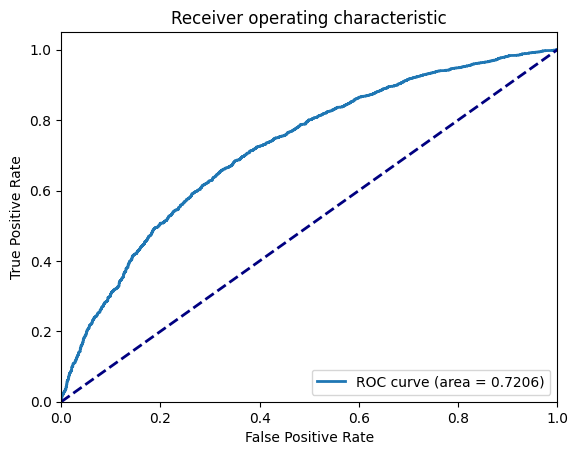

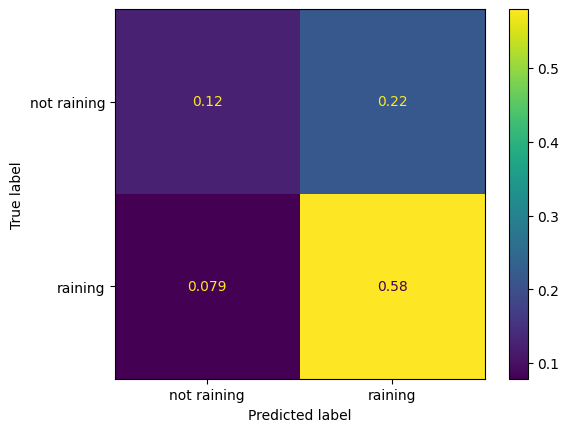

In [36]:
import sys
sys.path.append("../scripts")
import plotting

preds = torch.nn.functional.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy()
prediction_probability = preds[:,1]
predictions = preds.argmax(axis=-1)
truth = ds_test.raining.values
plotting.analysis.classification_report(labels=truth, predictions=predictions)
plotting.analysis.plot_roc(truth=truth, prediction_probability=prediction_probability)
plotting.plotting.analysis.check_prediction(truth=truth, prediction=predictions);

In [30]:

def load_saved_trained_model(ds, folder_to_model, db_config_base, model_nm, parameters):
    # load the pretrained tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(folder_to_model)
    db_config_base = transformers.AutoConfig.from_pretrained(
        folder_to_model, num_labels=2
    )
    dataset = get_dataset(ds, tok_func, tokenizer, indices_train, indices_test)
    trainer = get_trainer(
        dataset, db_config_base, folder_to_model, folder_to_model, parameters
    )
    return trainer


trainer_evaluate = load_saved_trained_model(
    ds_raw,
    FOLDER_TO_OUTPUT + FOLDER_TO_OUTPUT,
    db_config_base,
    model_nm,
    parameters,
)

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './outputs./outputs'. Use `repo_type` argument if needed.